<a href="https://colab.research.google.com/github/wilmi94/MasterThesis-AE/blob/main/notebooks/sdo_e2e_ConvLSTM_171.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SDO/AIA-171A End-to-End ConvLSTM Model

> This notebook is part of the Master Thesis *Predicting Coronal Mass Ejections using Machine Learning methods* by Wilmar Ender, FH Wiener Neustadt, 2023.

This notebook is considered the final model of the thesis and therefore includes the parts Data Preparation (section 4.4 in thesis), Model (section 4.5 in thesis) and Evaluation (section 4.6 in thesis).

**Objective:** \\
This notebook aims to perform the prediction of CMEs based on a given sequence of full-disk images from the SDO/AIA.

**Solar event list:** \\
*Liu et al. 2020, Predicting Coronal Mass Ejections Using SDO/HMI Vector Magnetic Data Products and Recurrent Neural Networks*

**Dataset:** \\
*Ahmadzadeh et al. 2019, A Curated Image Parameter Data Set from the Solar Dynamics Observatory Mission*. \\
Accessed via *sdo-cli* (https://github.com/i4Ds/sdo-cli)

*Predicting Solar Flares Using a Long Short-term Memory Network. Liu, H., Liu, C., Wang, J. T. L., Wang, H., ApJ., 877:121, 2019.*


...

## Setting up the Notebook

In [73]:
%%capture
pip install -U sdo-cli

In [171]:
import pandas as pd
import csv
import sys
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from google.colab import files

from keras.utils import np_utils
from keras.models import *
from keras.layers import *

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
try :
    import tensorflow as tf
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
except Exception as e:
    print('turn off loggins is not supported')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


import warnings
from keras.models import *
from keras.layers import *
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [75]:
# mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
# Change present working directory
%cd /content/drive/MyDrive/Academia/MSc. Aerospace Engineering - FH Wiener Neustadt/4. Master Thesis/03-Work/

/content/drive/MyDrive/Academia/MSc. Aerospace Engineering - FH Wiener Neustadt/4. Master Thesis/03-Work


In [77]:
# check content
!ls -a

 00_Dataset		   03_sdo_ConvLSTM			      .sdo-cli
 01_sdo_data_exploration   04_Tests
 02_sdo_binclass	  'Master Thesis-ML-Project-Checklist.gdoc'


## Helper Functions

In [78]:
def rename_files_in_folder(folder_path):
    # Check if the provided path is a directory
    if not os.path.isdir(folder_path):
        print(f"{folder_path} is not a directory.")
        return

    # Iterate through files in the directory
    for filename in os.listdir(folder_path):
        old_file_path = os.path.join(folder_path, filename)

        # Check if it's a file (not a directory)
        if os.path.isfile(old_file_path):
            # Split the filename and extension
            base_name, file_extension = os.path.splitext(filename)

            # Check if the filename contains "__171"
            if "__171" in base_name:
                # Remove the "__171" part
                new_base_name = base_name.replace("__171", "")
                new_filename = f"{new_base_name}{file_extension}"
                new_file_path = os.path.join(folder_path, new_filename)

                # Rename the file
                os.rename(old_file_path, new_file_path)
                print(f"Renamed: {filename} to {new_filename}")


In [79]:
def compare_filenames_with_dataframe(directory, dataframe):
    file_end = '.jpeg'
    # Get list of filenames from the directory
    directory_filenames = [filename for filename in os.listdir(directory) if filename.endswith(file_end)]

    # Get list of names from the DataFrame
    df_check = dataframe.copy()
    df_check['Timestamp'] = pd.to_datetime(df_check['Timestamp']).dt.strftime('%Y-%m-%dT%H%M%S.jpeg') # Warning! wavelength is now hard coded

    dataframe_names = df_check['Timestamp'].tolist()  # the name of the image should correspond to the timestamp

    # Compare filenames
    common_filenames = set(directory_filenames) & set(dataframe_names)
    missing_filenames = set(dataframe_names) - set(directory_filenames)
    extra_filenames = set(directory_filenames) - set(dataframe_names)

    df_missing = pd.DataFrame (data = missing_filenames,  columns=['Timestamp'])
    df_missing['Timestamp'] = df_missing['Timestamp'].str.replace(r'.jpeg', '', regex=True)
    df_missing['Timestamp'] = pd.to_datetime(df_missing['Timestamp']).dt.strftime('%Y-%m-%dT%H:%M:%S')

    # Calculate statistics
    total_directory_files = len(directory_filenames)
    total_dataframe_names = len(dataframe_names)
    total_common_files = len(common_filenames)
    total_missing_files = len(missing_filenames)
    total_extra_files = len(extra_filenames)
    print('Total Directory Files: ', total_directory_files)
    print('Total DataFrame Names: ', total_dataframe_names)
    print('Common Files: ', total_common_files)
    print('Missing Files: ', total_missing_files)
    print('Extra Files: ', total_extra_files)

    statistics = {
        'Total Directory Files': total_directory_files,
        'Total DataFrame Names': total_dataframe_names,
        'Common Files': total_common_files,
        'Missing Files': total_missing_files,
        'Extra Files': total_extra_files,
        #'Common File Names': common_filenames,
        'Missing File Names': missing_filenames,
        'Extra File Names': extra_filenames
    }

    return statistics, df_missing

## Create the Dataset

### Load Event-Lists

Same list from *Liu et al. 2020*, however the events were sampled for predicting CMEs within the next x hours (x = 12, 24, 36, 48 or 60).

> N means there is a >=M class flare within the next x hours but this flare is not associated with a CME. \\
> P means there is a >=M class flare within the next x hours and this flare is associated with a CME. \\
> The second column is titled Timestamp. \\
> The third column and fourth column are titled NOAA active region number and HARP number, respectively. \\
> Starting from the fifth column, you can see physical parameters of data samples, which include 18 SHARP parameters:
TOTUSJH, TOTPOT, TOTUSJZ, ABSNJZH, SAVNCPP, USFLUX, AREA_ACR, MEANPOT, R_VALUE, SHRGT45, MEANGAM, MEANJZH, MEANGBT, MEANGBZ, MEANJZD, MEANGBH, MEANSHR, MEANALP.

#### Base Event List

In [80]:
# load list with both (neg, pos) labels
df_cme_list = pd.read_csv(r'00_Dataset/event_lists/all_cme_events.csv', delimiter =';')

# convert time stamp such that sdo-cli can read them
df_cme_list['Start Time'] = pd.to_datetime(df_cme_list['Start Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_list['Peak Time'] = pd.to_datetime(df_cme_list['Peak Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_list['End Time'] = pd.to_datetime(df_cme_list['End Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_list.head()

,Flare Class,Start Time,Peak Time,End Time,Active Region Number,Harp Number,CME
0,M1.2,2010-05-05T17:13:00,2010-05-05T17:19:00,2010-05-05T17:22:00,11069,8,No
1,M1.0,2010-06-13T05:30:00,2010-06-13T05:39:00,2010-06-13T05:44:00,11079,49,No
2,M2.0,2010-06-12T00:30:00,2010-06-12T00:57:00,2010-06-12T01:02:00,11081,54,No
3,M1.0,2010-08-07T17:55:00,2010-08-07T18:24:00,2010-08-07T18:47:00,11093,115,No
4,M2.9,2010-10-16T19:07:00,2010-10-16T19:12:00,2010-10-16T19:15:00,11112,211,No


#### Training List

In [81]:
# load list with both (neg, pos) labels of training list for t= 12 h prediction window
df_cme_training_12 = pd.read_csv(r'00_Dataset/event_lists/Liu2020_CME_data_samples/normalized_training_12.csv', delimiter =',')
df_cme_training_12.shape


(20347, 22)

In [82]:
df_cme_training_12.head()

,Label,Timestamp,NOAA_AR_NUM,HARP_NUM,TOTUSJH,TOTPOT,TOTUSJZ,ABSNJZH,SAVNCPP,USFLUX,...,R_VALUE,SHRGT45,MEANGAM,MEANJZH,MEANGBT,MEANGBZ,MEANJZD,MEANGBH,MEANSHR,MEANALP
0,N,2010-05-05T05:22:22.90Z,11069,8,-0.5461,-0.5672,-0.6696,0.3159,0.2083,-0.7610,...,0.3751,-0.4109,-0.1049,-3.3554,0.5327,0.6921,-0.1673,0.5768,-0.1024,-1.1464
1,N,2010-05-05T05:34:22.90Z,11069,8,-0.5438,-0.5635,-0.6607,0.3360,0.2741,-0.7552,...,0.3969,-0.3188,-0.0283,-3.2984,0.4808,0.6302,-0.0497,0.5683,-0.0324,-1.1596
2,N,2010-05-05T05:46:22.90Z,11069,8,-0.5469,-0.5604,-0.6521,0.3315,0.3650,-0.7518,...,0.3961,-0.2149,0.0489,-3.1799,0.4268,0.5787,-0.1523,0.5588,0.0503,-1.1509
3,N,2010-05-05T06:22:22.90Z,11069,8,-0.5275,-0.5546,-0.6356,0.3042,0.2075,-0.7346,...,0.3842,-0.2724,0.0144,-2.9791,0.4130,0.5345,-0.0549,0.5549,0.0166,-1.0816
4,N,2010-05-05T06:34:22.90Z,11069,8,-0.5212,-0.5481,-0.6294,0.3653,0.2579,-0.7322,...,0.3554,-0.2530,0.0585,-3.1240,0.4596,0.6073,0.1217,0.5626,0.0660,-1.1460


In [83]:
# reduce dataframe to relevant columns
df_cme_training_12 = df_cme_training_12.drop(['TOTUSJH',	'TOTPOT',	'TOTUSJZ',	'ABSNJZH',	'SAVNCPP',
                     'USFLUX', 'AREA_ACR', 'MEANPOT', 'R_VALUE', 'SHRGT45',
                     'MEANGAM', 'MEANJZH', 'MEANGBT', 'MEANGBZ', 'MEANJZD',
                     'MEANGBH', 'MEANSHR', 'MEANALP'], axis=1)


In [84]:
df_cme_training_12['Timestamp'] = pd.to_datetime(df_cme_training_12['Timestamp']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_training_12.head()

,Label,Timestamp,NOAA_AR_NUM,HARP_NUM
0,N,2010-05-05T05:22:22,11069,8
1,N,2010-05-05T05:34:22,11069,8
2,N,2010-05-05T05:46:22,11069,8
3,N,2010-05-05T06:22:22,11069,8
4,N,2010-05-05T06:34:22,11069,8


In [85]:
df_cme_training_12 = df_cme_training_12.tail(df_cme_training_12.shape[0] -282)
df_cme_training_12

,Label,Timestamp,NOAA_AR_NUM,HARP_NUM
282,N,2011-02-08T13:46:11,11153,362
283,N,2011-02-08T13:58:11,11153,362
284,N,2011-02-08T14:10:11,11153,362
285,N,2011-02-08T14:22:11,11153,362
286,N,2011-02-08T14:34:11,11153,362
...,...,...,...,...
20342,N,2016-01-01T21:22:08,12473,6206
20343,N,2016-01-01T21:34:08,12473,6206
20344,N,2016-01-01T21:46:08,12473,6206
20345,N,2016-01-01T21:58:08,12473,6206


In [86]:
# get negative samples
df_cme_training_12_neg = df_cme_training_12.loc[df_cme_training_12['Label'] == 'N']
df_cme_training_12_neg = df_cme_training_12_neg.reset_index(drop=True)
print('There are', df_cme_training_12_neg.shape[0], 'negative samples in the training set.\n')
df_cme_training_12_neg.tail()

There are 16678 negative samples in the training set.



,Label,Timestamp,NOAA_AR_NUM,HARP_NUM
16673,N,2016-01-01T21:22:08,12473,6206
16674,N,2016-01-01T21:34:08,12473,6206
16675,N,2016-01-01T21:46:08,12473,6206
16676,N,2016-01-01T21:58:08,12473,6206
16677,N,2016-01-01T22:22:08,12473,6206


In [87]:
# get positive samples
df_cme_training_12_pos = df_cme_training_12.loc[df_cme_training_12['Label'] == 'P']
df_cme_training_12_pos = df_cme_training_12_pos.reset_index(drop = True)
print('There are', df_cme_training_12_pos.shape[0], 'positive samples in the training set.\n')
df_cme_training_12_pos.tail()

There are 3387 positive samples in the training set.



,Label,Timestamp,NOAA_AR_NUM,HARP_NUM
3382,P,2015-12-28T11:46:08,12473,6206
3383,P,2015-12-28T11:58:08,12473,6206
3384,P,2015-12-28T12:10:08,12473,6206
3385,P,2015-12-28T12:22:08,12473,6206
3386,P,2015-12-28T12:34:08,12473,6206


#### Testing List

In [88]:
# load list with both (neg, pos) labels of testing list for t= 12 h
df_cme_test_12 = pd.read_csv(r'00_Dataset/event_lists/Liu2020_CME_data_samples/normalized_testing_12.csv', delimiter =',')
df_cme_test_12.head()

,Label,Timestamp,NOAA_AR_NUM,HARP_NUM,TOTUSJH,TOTPOT,TOTUSJZ,ABSNJZH,SAVNCPP,USFLUX,...,R_VALUE,SHRGT45,MEANGAM,MEANJZH,MEANGBT,MEANGBZ,MEANJZD,MEANGBH,MEANSHR,MEANALP
0,N,2016-02-11T22:58:09.90Z,12497,6327,0.3925,-0.2331,0.4536,0.9205,1.0290,-0.0909,...,0.3442,-0.0754,0.3384,-1.6783,1.2374,1.1869,0.5194,0.6876,0.1579,-0.7577
1,N,2016-02-11T23:10:09.90Z,12497,6327,0.4030,-0.2328,0.4527,0.9448,0.9703,-0.0821,...,0.3969,-0.1284,0.3151,-1.6798,1.2349,1.1826,1.1634,0.6851,0.1416,-0.7672
2,N,2016-02-11T23:22:09.90Z,12497,6327,0.4127,-0.2295,0.4665,1.0729,1.1235,-0.0793,...,0.4348,-0.1012,0.3018,-1.8024,1.2517,1.1898,1.1432,0.6877,0.1457,-0.8262
3,N,2016-02-11T23:34:10.00Z,12497,6327,0.4183,-0.2292,0.4679,1.0541,1.0207,-0.0777,...,0.4516,-0.1595,0.2761,-1.7795,1.2329,1.1921,1.2066,0.6774,0.1143,-0.8189
4,N,2016-02-11T23:46:10.00Z,12497,6327,0.3991,-0.2277,0.4601,1.1108,1.0915,-0.0865,...,0.4488,-0.1515,0.2837,-1.8467,1.2195,1.1594,1.0569,0.6803,0.1153,-0.8529


In [89]:
# reduce dataframe to relevant columns
df_cme_test_12 = df_cme_test_12.drop(['TOTUSJH',	'TOTPOT',	'TOTUSJZ',	'ABSNJZH',	'SAVNCPP',
                     'USFLUX', 'AREA_ACR', 'MEANPOT', 'R_VALUE', 'SHRGT45',
                     'MEANGAM', 'MEANJZH', 'MEANGBT', 'MEANGBZ', 'MEANJZD',
                     'MEANGBH', 'MEANSHR', 'MEANALP'], axis=1)
df_cme_test_12.head()

,Label,Timestamp,NOAA_AR_NUM,HARP_NUM
0,N,2016-02-11T22:58:09.90Z,12497,6327
1,N,2016-02-11T23:10:09.90Z,12497,6327
2,N,2016-02-11T23:22:09.90Z,12497,6327
3,N,2016-02-11T23:34:10.00Z,12497,6327
4,N,2016-02-11T23:46:10.00Z,12497,6327


In [90]:
# convert time stamp
# convert time stamp such that sdo-cli can read them
df_cme_test_12['Timestamp'] = pd.to_datetime(df_cme_test_12['Timestamp']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_test_12.tail()

,Label,Timestamp,NOAA_AR_NUM,HARP_NUM
1307,N,2017-09-08T21:46:41,12673,7115
1308,N,2017-09-08T21:58:41,12673,7115
1309,N,2017-09-08T22:10:41,12673,7115
1310,N,2017-09-08T22:22:41,12673,7115
1311,N,2017-09-08T22:34:41,12673,7115


In [91]:
df_cme_test_12_neg = df_cme_test_12.loc[df_cme_test_12['Label'] == 'N']
df_cme_test_12_neg = df_cme_test_12_neg.reset_index(drop=True)
print('There are', df_cme_test_12_neg.shape[0], 'negative samples in the test set.\n')
df_cme_test_12_neg.tail()

There are 762 negative samples in the test set.



,Label,Timestamp,NOAA_AR_NUM,HARP_NUM
757,N,2017-09-08T21:46:41,12673,7115
758,N,2017-09-08T21:58:41,12673,7115
759,N,2017-09-08T22:10:41,12673,7115
760,N,2017-09-08T22:22:41,12673,7115
761,N,2017-09-08T22:34:41,12673,7115


In [92]:
df_cme_test_12_pos = df_cme_test_12.loc[df_cme_test_12['Label'] == 'P']
df_cme_test_12_pos = df_cme_test_12_pos.reset_index(drop=True)
print('There are', df_cme_test_12_pos.shape[0], 'positive samples in the test set.\n')
df_cme_test_12_pos.tail()

There are 550 positive samples in the test set.



,Label,Timestamp,NOAA_AR_NUM,HARP_NUM
545,P,2017-09-08T05:10:41,12673,7115
546,P,2017-09-08T05:22:41,12673,7115
547,P,2017-09-08T05:34:41,12673,7115
548,P,2017-09-08T05:46:41,12673,7115
549,P,2017-09-08T06:10:41,12673,7115


In [93]:
# Usage
folder_path = '00_Dataset/Liu2020_sampled/test_12/pos/'  # Replace with your Google Drive folder path
rename_files_in_folder(folder_path)

00_Dataset/Liu2020_sampled/test_12/pos/ is not a directory.


By now we have four event lists from the sampled dataset:


*   df_cme_test_12_neg >> 762
*   df_cme_test_12_pos >> 550
*   df_cme_training_12_neg >> 16678
*   df_cme_training_12_pos >> 3387 samples


### Download and Check the Image-Data

#### Training - negative

In [94]:
!ls

 00_Dataset		   03_sdo_ConvLSTM
 01_sdo_data_exploration   04_Tests
 02_sdo_binclass	  'Master Thesis-ML-Project-Checklist.gdoc'


In [95]:
# create_sdo_aia_dataset(output_dir = './data/Liu2020_sampled/train/neg/', start_idx=0,  event_list = df_cme_training_12_neg, dt = '10min', wavelength = '171')

In [96]:
directory_path_training_12_neg = '00_Dataset/Liu2020_sampled/train/neg/'
result_training_12_neg, missing_files_training_neg = compare_filenames_with_dataframe(directory_path_training_12_neg, df_cme_training_12_neg)

Total Directory Files:  15361
Total DataFrame Names:  16678
Common Files:  15361
Missing Files:  496
Extra Files:  0


In [108]:
result_training_12_neg['Common Files']

15361

#### Training - positive

In [97]:
# create_sdo_aia_dataset(output_dir = './data/Liu2020_sampled/train/pos/', start_idx=0, event_list = df_cme_training_12_pos, dt = '10min', wavelength = '171')

In [98]:
directory_path_training_12_pos = '00_Dataset/Liu2020_sampled/train/pos/'
result_training_12_pos, missing_files_training_pos = compare_filenames_with_dataframe(directory_path_training_12_pos, df_cme_training_12_pos)

Total Directory Files:  3144
Total DataFrame Names:  3387
Common Files:  3144
Missing Files:  113
Extra Files:  0


In [126]:
total_training_files = result_training_12_pos['Common Files'] + result_training_12_neg['Common Files']
print('There are ', total_training_files, ' total training files' )

There are  18505  total training files


#### Testing - negative

In [99]:
# create_sdo_aia_dataset(output_dir = './data/Liu2020_sampled/test_12/neg/', start_idx=0, event_list = df_cme_test_12_neg, dt = '10min', wavelength = '171')

In [129]:
directory_path_test_12_neg = '00_Dataset/Liu2020_sampled/test/neg/'
result_test_12_neg, missing_files_test_neg = compare_filenames_with_dataframe(directory_path_test_12_neg, df_cme_test_12_neg)

Total Directory Files:  739
Total DataFrame Names:  762
Common Files:  739
Missing Files:  23
Extra Files:  0


#### Testing - positive

In [101]:
# create_sdo_aia_dataset(output_dir = './data/Liu2020_sampled/test_12/pos/', start_idx= 0, event_list = df_cme_test_12_pos, dt = '10min', wavelength = '171')

In [128]:
directory_path_test_12_pos = '00_Dataset/Liu2020_sampled/test/pos/'
result_test_12_pos, missing_test_pos = compare_filenames_with_dataframe(directory_path_test_12_pos, df_cme_test_12_pos)

Total Directory Files:  550
Total DataFrame Names:  550
Common Files:  549
Missing Files:  1
Extra Files:  1


In [131]:
total_testing_files = result_test_12_neg['Common Files'] + result_test_12_pos['Common Files']
print('There are ', total_testing_files, ' total testing files' )

There are  1288  total testing files


### Update Event Lists

Since not all data samples could be downloaded, the event lists have to be adjusted acordingly.

In [118]:
import pandas as pd
import os
from datetime import datetime

def create_csv_from_directory(dataframe, directory_path, output_csv_path):
    # Initialize an empty list to store timestamp-label pairs
    timestamp_label_pairs = []

    # Use os.walk to recursively traverse the directory and its subfolders
    for root, _, files in os.walk(directory_path):
        for file_name in files:
            # Extract the timestamp from the file name
            parts = file_name.split('T')
            if len(parts) == 2:
                file_timestamp_str = parts[0] + 'T' + parts[1].split('.')[0]
            else:
                # Handle invalid file name format
                continue

            try:
                # Convert the file timestamp string to a datetime object
                file_timestamp = datetime.strptime(file_timestamp_str, '%Y-%m-%dT%H%M%S')
            except ValueError:
                # Handle invalid timestamp format
                continue

            # Find the corresponding row in the DataFrame based on the timestamp
            matching_row = dataframe[dataframe['Timestamp'] == file_timestamp.strftime('%Y-%m-%dT%H:%M:%S')]

            if not matching_row.empty:
                # Get the label from the matching row
                label = matching_row.iloc[0]['Label']

                # Append the timestamp-label pair to the list
                timestamp_label_pairs.append((file_timestamp_str, label))

    # Create a new DataFrame from the list of timestamp-label pairs
    result_df = pd.DataFrame(timestamp_label_pairs, columns=['Timestamp', 'Label'])

    # Save the DataFrame to a CSV file
    result_df.to_csv(output_csv_path, index=False)



In [132]:
train_dir_path = '00_Dataset/Liu2020_sampled/train'
output_train_csv_path = '00_Dataset/Liu2020_sampled/train/train_label.csv'

create_csv_from_directory(df_cme_training_12, train_dir_path , output_train_csv_path)

In [260]:
train_label_csv = pd.read_csv(r'00_Dataset/Liu2020_sampled/train/train_label.csv', delimiter =',')
train_label_csv

,Timestamp,Label
0,2011-03-25T114617,N
1,2011-03-25T115817,N
2,2011-03-25T121017,N
3,2011-03-25T122217,N
4,2011-03-25T123417,N
...,...,...
18500,2015-02-09T142210,P
18501,2015-02-09T143410,P
18502,2015-02-09T144610,P
18503,2015-02-09T145810,P


In [261]:
test_dir_path = '00_Dataset/Liu2020_sampled/test'
output_test_csv_path = '00_Dataset/Liu2020_sampled/test/test_label.csv'

create_csv_from_directory(df_cme_test_12, test_dir_path, output_test_csv_path)
test_label_csv = pd.read_csv(r'00_Dataset/Liu2020_sampled/test/test_label.csv', delimiter =',')
test_label_csv

,Timestamp,Label
0,2016-02-11T225809,N
1,2016-02-11T231009,N
2,2016-02-11T232209,N
3,2016-02-11T233410,N
4,2016-02-11T234610,N
...,...,...
1283,2017-09-08T051041,P
1284,2017-09-08T052241,P
1285,2017-09-08T053441,P
1286,2017-09-08T054641,P


### Display a Sample Image-Series

## Data Preparation

In [252]:
def load_data(data_dir, df, series_len, image_shape):
    X = []  # List to store input sequences (image sequences)
    y = []  # List to store target labels
    n_pos = 0  # Number of positive samples
    n_neg = 0  # Number of negative samples

    for row in df.itertuples(index=False):
        filename = row.Timestamp + '.jpeg'
        label = row.Label

    # for index, row in df.iterrows():
    #     filename = row['Timestamp'] + '.jpeg'
    #     label = row['Label']

        if label not in ['N', 'P']:
            continue  # Skip entries with invalid labels

        if label == 'N':
          path_label = 'neg'
        else:
          path_label = 'pos'

        # Construct the full path to the image file
        image_path = os.path.join(data_dir, path_label, filename)

        # Read and preprocess the image
        image = cv2.imread(image_path)
        image = cv2.resize(image, image_shape)  # Resize the image to the desired shape
        image = image / 255.0  # Normalize pixel values to the range [0, 1]

        if len(X) < series_len:
            X.insert(0, image)  # Add the image to the input sequence

        if len(X) == series_len:
            X_arr = np.array(X)  # Convert the input sequence to a NumPy array
            X_arr = X_arr.reshape(series_len, *image_shape)  # Reshape to (series_len, height, width, channels)
            X.append(X_arr)  # Append the sequence to the list of input sequences
            if label == 'P':
                y.append(1)  # Positive label
                n_pos += 1
            else:
                y.append(0)  # Negative label
                n_neg += 1

        if len(X) > series_len:
            del X[0]  # Remove the oldest image from the sequence

    X = np.array(X)  # Convert the list of sequences to a NumPy array
    y = np.array(y)  # Convert the list of labels to a NumPy array
    nb = n_pos + n_neg  # Total number of samples

    return X, y, nb


In [230]:
for row in train_label_csv.itertuples(index=False):
    filename = row.Timestamp
    label = row.Label

In [222]:
for index, row in train_label_csv.iterrows():
    filename = row['Timestamp'] + '.jpeg'
    label = row['Label']

In [233]:
filename, label #= '2011-03-25T114617.jpeg'


('2015-02-09T151010', 'P')

In [224]:
image_path = os.path.join(train_dir_path, 'pos', filename)
image_path

'00_Dataset/Liu2020_sampled/train/pos/2015-02-09T151010.jpeg'

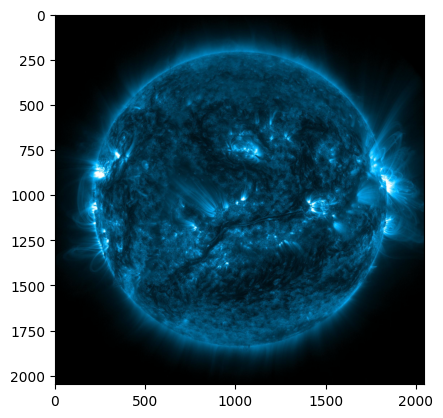

In [225]:
image = cv2.imread(image_path)
plt.imshow(image)

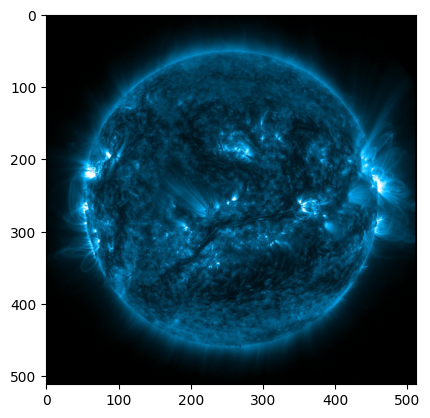

In [226]:
 image = cv2.resize(image, image_shape)
 plt.imshow(image)

In [253]:
series_len = 20
image_shape = (256, 256)

In [254]:
X_train, y_train, nb_train = load_data(data_dir= train_dir_path,
                                       df = train_label_csv,
                                       series_len=series_len,
                                       image_shape=image_shape)

ValueError: ignored

In [229]:
X_test, y_test, nb_test = load_data(data_dir= test_dir_path,
                                    df = test_label_csv,
                                    series_len=series_len,
                                    image_shape=image_shape)

error: ignored

In [272]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

def load_and_preprocess_data(data_dir, df, series_len, image_shape, batch_size=32, shuffle_data=True):
    data = []
    labels = []

    if shuffle_data:
        df = shuffle(df)

    for index, row in df.iterrows():
        filename = row['Timestamp']
        label = row['Label']

        # Construct the full path to the image file
        image_path = os.path.join(data_dir, label, filename)

        # Read and preprocess the image
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.resize(image, image_shape)  # Resize the image to the desired shape
            image = image / 255.0  # Normalize pixel values to the range [0, 1]

            data.append(image)
            if label == 'P':
                labels.append(1)  # Positive label
            else:
                labels.append(0)  # Negative label

    data = np.array(data)  # Convert the list of sequences to a NumPy array
    labels = np.array(labels)  # Convert the list of labels to a NumPy array

    return data, labels

# Example usage:
train_data, train_labels = load_and_preprocess_data(train_dir_path, train_label_csv, series_len, image_shape)
test_data, test_labels = load_and_preprocess_data(test_dir_path, test_label_csv, series_len, image_shape)


In [273]:
train_data

array([], dtype=float64)

In [262]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def data_generator(data_dir, label_csv, batch_size, image_shape, shuffle=True):
    # Create an ImageDataGenerator with the desired preprocessing options
    datagen = ImageDataGenerator(
        rescale=1./255,  # Normalize pixel values to the range [0, 1]
        validation_split=0.2,  # Split data into training and validation sets
    )

    # Create data generators for the training and validation sets
    train_generator = datagen.flow_from_dataframe(
        dataframe=label_csv,
        directory=data_dir,
        x_col="Timestamp",  # Column containing the image filenames
        y_col="Label",     # Column containing the labels
        target_size=image_shape,  # Desired image shape
        batch_size=batch_size,
        class_mode="binary",  # Assumes binary classification (pos/neg)
        subset="training",  # Use the training subset
        shuffle=shuffle
    )

    validation_generator = datagen.flow_from_dataframe(
        dataframe=label_csv,
        directory=data_dir,
        x_col="Timestamp",
        y_col="Label",
        target_size=image_shape,
        batch_size=batch_size,
        class_mode="binary",
        subset="validation",  # Use the validation subset
        shuffle=shuffle
    )

    return train_generator, validation_generator


In [265]:
series_len = 20
image_shape = (256, 256)
batch_size = 32

train_generator, validation_generator = data_generator(train_dir_path, train_label_csv, batch_size, image_shape, shuffle=True)

Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.


Make sure to replace '/path/to/data', '/path/to/labels.csv', '/path/to/train', '/path/to/train_labels.csv', '/path/to/test', and '/path/to/test_labels.csv' with the actual paths to your data directory, label CSV file, and subdirectories containing positive and negative samples.

This modified load_data function reads the image files, resizes them, normalizes pixel values, and constructs input sequences for the ConvLSTM model. It also reads labels from the CSV file and assigns binary labels (1 for positive, 0 for negative). Adjust the image_shape variable to match the desired image dimensions for your model.

## Build the ConvLSTM Model


Certainly! Here's a ConvLSTM model proposal based on the load_data function and the prediction task you mentioned earlier. This model will take a sequence of solar images as input and predict whether a solar flare will initiate a Coronal Mass Ejection (CME).

In [150]:
from keras.models import Sequential
from keras.layers import ConvLSTM2D, MaxPooling2D, Flatten, Dense, Dropout

def convlstm_model(image_shape, series_len):
    model = Sequential()

    # ConvLSTM layer with 32 filters
    model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), input_shape=(series_len, *image_shape),
                         activation='relu', return_sequences=True))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # ConvLSTM layer with 64 filters
    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu', return_sequences=True))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the output of ConvLSTM layers
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Dropout for regularization
    model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation

    return model



In [151]:
# Define image dimensions and sequence length
image_shape = (512, 512)  # Adjust to your desired image dimensions
series_len = 20  # Adjust as needed

# Create the ConvLSTM model
model = convlstm_model(image_shape, series_len)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display model summary
model.summary()

ValueError: ignored

In this proposed ConvLSTM model:

1. The model starts with a ConvLSTM2D layer with 32 filters and a kernel size of (3, 3). It takes input sequences of solar images with the specified shape and uses the ReLU activation function. This layer returns sequences of feature maps.

2. After each ConvLSTM2D layer, a MaxPooling2D layer is applied to downsample the spatial dimensions of the feature maps.

3. The output of the last ConvLSTM2D layer is flattened to create a one-dimensional feature vector.

4. Two fully connected (Dense) layers follow. The first Dense layer has 128 units with ReLU activation, and a dropout layer is added for regularization.

5. The final Dense layer has a single unit with a sigmoid activation function, which is suitable for binary classification tasks.

6. The model is compiled with binary cross-entropy loss and the Adam optimizer.

You can further fine-tune this model and adjust hyperparameters as needed for your specific task. Additionally, you can train the model using the training data and evaluate its performance on the testing data as mentioned in your original code.

## Train the model

In [ ]:
#type = 'convlstm'  # We're using ConvLSTM for the new prediction task
time_window = 12  # Adjust this as needed
train_again = 1  # Set to 1 to train the model again or 0 to load a pre-trained model
train_data_file = './normalized_training_' + str(time_window) + '.csv'
test_data_file = './normalized_testing_' + str(time_window) + '.csv'
result_file = './convlstm-' + str(time_window) + '-output.csv'
model_file = './convlstm-' + str(time_window) + '-model.h5'
start_feature = 4
mask_value = 0
series_len = 20
epochs = 20
batch_size = 256

In [ ]:
# Load or train the ConvLSTM model based on the new task
if train_again == 1:
    # # Load and preprocess training data
    # print('loading training data...')
    # X_train, y_train, nb_train = load_data(datafile=train_data_file,
    #                                         series_len=series_len,
    #                                         start_feature=start_feature,
    #                                         n_features=n_features,
    #                                         mask_value=mask_value,
    #                                         time_window=time_window)

    # Compute class weights for imbalance
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
    class_weight_ = {0: class_weights[0], 1: class_weights[1]}
    print('done loading training data...')

    # Create and train the ConvLSTM model
    # print('training the model, wait until it is finished...')
    # model = convlstm(n_features, series_len)
    # model.compile(loss='binary_crossentropy',
    #               optimizer='RMSprop',
    #               metrics=['accuracy'])
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=False,
                        shuffle=True,
                        class_weight=class_weight_)
    print('finished...')

    # Save the trained model
    model.save(model_file)
else:
    # Load a pre-trained ConvLSTM model
    print('loading model...')
    model = load_model(model_file)
    print('done loading...')


In this modified code:

1. The type is set to 'convlstm' to indicate the use of ConvLSTM for the new prediction task.

2. The convlstm function is a placeholder where you should define the architecture of your ConvLSTM model. You can design the ConvLSTM layers and any additional layers you need for your specific task.

3. The logic for loading data, training the model, and making predictions remains similar to the original code, with minor adjustments for the ConvLSTM model.

4. Ensure that you have the appropriate data files and adjust the time_window parameter according to your new task.

5. The output_result function should be updated to match the format of the new prediction task's output.

You'll need to define the ConvLSTM model architecture in the convlstm function, specifying the layers, activations, and any other hyperparameters required for your specific prediction task.

## Test the model

In [ ]:
# Test the model
print('loading testing data')
X_test, y_test, nb_test = load_data(datafile=test_data_file,
                                    series_len=series_len,
                                    start_feature=start_feature,
                                    n_features=n_features,
                                    mask_value=mask_value,
                                    time_window=time_window)
print('done loading testing data...')

# Predict and write results
print('predicting testing data...')
prob = model.predict(X_test,
                      batch_size=batch_size,
                      verbose=False,
                      steps=None)
print('done predicting...')

# Write prediction results into a file
print('writing prediction results into file...')
output_result(test_data_file=test_data_file,
              result_file=result_file,
              thresh=thresh)
print('done...')

## Evaluate the Model

# Graveyard

### try: ChatGPT

In [ ]:
# def load_data(datafile, flare_label, series_len, start_feature, n_features, mask_value):
#     df = pd.read_csv(datafile)
#     df_values = df.values
#     X = []
#     y = []
#     tmp = []
#     for k in range(start_feature, start_feature + n_features):
#         tmp.append(mask_value)
#     for idx in range(0, len(df_values)):
#         each_series_data = []
#         row = df_values[idx]
#         label = row[1][0]
#         if flare_label == 'C' and (label == 'X' or label == 'M'):
#             label = 'C'
#         if flare_label == 'C' and label == 'B':
#             label = 'N'
#         has_zero_record = False
#         # if at least one of the 25 physical feature values is missing, then discard it.
#         if flare_label == 'C':
#             if float(row[5]) == 0.0:
#                 has_zero_record = True
#             if float(row[7]) == 0.0:
#                 has_zero_record = True
#             for k in range(9, 13):
#                 if float(row[k]) == 0.0:
#                     has_zero_record = True
#                     break
#             for k in range(14, 16):
#                 if float(row[k]) == 0.0:
#                     has_zero_record = True
#                     break
#             if float(row[18]) == 0.0:
#                 has_zero_record = True

#         if has_zero_record is False:
#             cur_noaa_num = int(row[3])
#             each_series_data.append(row[start_feature:start_feature + n_features].tolist())
#             itr_idx = idx - 1
#             while itr_idx >= 0 and len(each_series_data) < series_len:
#                 prev_row = df_values[itr_idx]
#                 prev_noaa_num = int(prev_row[3])
#                 if prev_noaa_num != cur_noaa_num:
#                     break
#                 has_zero_record_tmp = False
#                 if flare_label == 'C':
#                     if float(row[5]) == 0.0:
#                         has_zero_record_tmp = True
#                     if float(row[7]) == 0.0:
#                         has_zero_record_tmp = True
#                     for k in range(9, 13):
#                         if float(row[k]) == 0.0:
#                             has_zero_record_tmp = True
#                             break
#                     for k in range(14, 16):
#                         if float(row[k]) == 0.0:
#                             has_zero_record_tmp = True
#                             break
#                     if float(row[18]) == 0.0:
#                         has_zero_record_tmp = True

#                 if len(each_series_data) < series_len and has_zero_record_tmp is True:
#                     each_series_data.insert(0, tmp)

#                 if len(each_series_data) < series_len and has_zero_record_tmp is False:
#                     each_series_data.insert(0, prev_row[start_feature:start_feature + n_features].tolist())
#                 itr_idx -= 1

#             while len(each_series_data) > 0 and len(each_series_data) < series_len:
#                 each_series_data.insert(0, tmp)

#             if len(each_series_data) > 0:
#                 X.append(np.array(each_series_data).reshape(series_len, n_features).tolist())
#                 y.append(label)
#     X_arr = np.array(X)
#     y_arr = np.array(y)
#     print(X_arr.shape)
#     return X_arr, y_arr


# def data_transform(data):
#     encoder = LabelEncoder()
#     encoder.fit(data)
#     encoded_Y = encoder.transform(data)
#     converteddata = np_utils.to_categorical(encoded_Y)
#     return converteddata

In [ ]:
# import os
# import numpy as np
# import cv2

# def load_images_from_folder(folder_path):
#     images = []
#     for filename in os.listdir(folder_path):
#         img = cv2.imread(os.path.join(folder_path, filename))
#         if img is not None:
#             images.append(img)
#     return images

# def create_dataset(data_folder, sequence_length, target_time_steps):
#     dataset = []
#     labels = []

#     for event_folder in os.listdir(data_folder):
#         event_path = os.path.join(data_folder, event_folder)
#         event_images = load_images_from_folder(event_path)

#         # Create sequences for the event images
#         event_sequences = create_sequences(event_images, sequence_length)

#         # Create labels for the event sequences
#         event_labels = create_labels(event_sequences, target_time_steps)

#         # Append the event sequences and labels to the main dataset
#         dataset.extend(event_sequences)
#         labels.extend(event_labels)

#     return np.array(dataset), np.array(labels)

# # Function to create sequences of AIA images with a fixed time duration
# def create_sequences(images, sequence_length):
#     sequences = []
#     num_images = len(images)
#     for i in range(0, num_images - sequence_length + 1, sequence_length):
#         sequence = images[i:i + sequence_length]
#         sequences.append(sequence)
#     return sequences

# # Function to create target labels for sequences
# def create_labels(sequences, target_time_steps):
#     labels = []
#     for sequence in sequences:
#         # Check if a CME occurs within the next target_time_steps
#         cme_occurs = any(sequence[i]['CME_occurs'] for i in range(target_time_steps))
#         labels.append(int(cme_occurs))
#     return labels

# # Assuming the AIA image data is organized in separate event folders within the 'data_folder'
# data_folder = '/path/to/data_folder'
# sequence_length = 6  # Choose the number of images in each sequence
# target_time_steps = 12  # Choose the time steps (intervals) for predicting CME occurrence

# # Create the dataset and labels
# dataset, labels = create_dataset(data_folder, sequence_length, target_time_steps)


### try 2: DS creation from Chat GPT

In [ ]:
data_dir = '00_Dataset/Liu2020_sampled/'

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_images_from_directory(directory):
    images = []
    timestamps = []
    for label in sorted(os.listdir(directory)):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for filename in sorted(os.listdir(label_dir)):
                if filename.endswith(".jpeg"):
                    img = load_img(os.path.join(label_dir, filename))
                    img_array = img_to_array(img)
                    images.append(img_array)
                    timestamp = filename.split(".")[0]  # Adjust the split based on your filename format
                    timestamps.append(timestamp)
    return images, timestamps

In [ ]:
os.listdir(data_dir)

In [ ]:
load_images_from_directory('00_Dataset/Liu2020_sampled/test/pos')

In [ ]:
def create_conv_lstm_dataset(data_dir, T, test_size=0.2):
    pos_dir = os.path.join(data_dir, 'train', 'pos')
    neg_dir = os.path.join(data_dir, 'train', 'neg')

    pos_images, pos_timestamps = load_images_from_directory(pos_dir)
    neg_images, neg_timestamps = load_images_from_directory(neg_dir)

    all_images = np.array(pos_images + neg_images)
    all_timestamps = pos_timestamps + neg_timestamps
    labels = np.array([1] * len(pos_images) + [0] * len(neg_images))

    X = []
    y = []

    for i in range(len(all_images) - T):
        sequence = all_images[i:i + T]
        label = labels[i + T]
        X.append(sequence)
        y.append(label)

    X = np.array(X)
    y = np.array(y)

    X_train, X_test, y_train, y_test, timestamps_train, timestamps_test = train_test_split(
        X, y, all_timestamps[T:], test_size=test_size, random_state=42
    )

    return X_train, y_train, X_test, y_test, timestamps_train, timestamps_test


In [ ]:
T = 20  # Number of time steps for the ConvLSTM sequence
X_train, y_train, X_test, y_test, timestamps_train, timestamps_test = create_conv_lstm_dataset(data_dir, T, test_size=0.2)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Define your ConvLSTM model using Keras here
# ...

# Compile and train the model
# model.compile(...)
# model.fit(...)


In [ ]:
# flare_label = sys.argv[1]
# train_again = int(sys.argv[2])
# filepath = './'
# n_features = 0
# if flare_label == 'C':
#   n_features = 14
# start_feature = 5
# mask_value = 0
# series_len = 10
# epochs = 7
# batch_size = 256
# nclass = 2
# result_file = './output.csv'

In [ ]:
# if train_again == 1:
#     # Train
#     X_train_data, y_train_data = load_data(datafile=filepath + 'normalized_training.csv',
#                                             flare_label=flare_label, series_len=series_len,
#                                             start_feature=start_feature, n_features=n_features,
#                                             mask_value=mask_value)

#     X_train = np.array(X_train_data)
#     y_train = np.array(y_train_data)
#     y_train_tr = data_transform(y_train)

#     class_weights = class_weight.compute_class_weight('balanced',
#                                                       np.unique(y_train), y_train)
#     class_weight_ = {0: class_weights[0], 1: class_weights[1]}
#     # print(class_weight_)

#     model = lstm(nclass, n_features, series_len)
#     model.compile(loss='categorical_crossentropy',
#                   optimizer='adam',
#                   metrics=['accuracy'])

#     history = model.fit(X_train, y_train_tr,
#                         epochs=epochs, batch_size=batch_size,
#                         verbose=False, shuffle=True, class_weight=class_weight_)
#     model.save('./model.h5')
# else:
#     model = load_model('./model.h5')

#     # Test
#     X_test_data, y_test_data = load_data(datafile=filepath + 'normalized_testing.csv',
#                                          flare_label=flare_label, series_len=series_len,
#                                          start_feature=start_feature, n_features=n_features,
#                                          mask_value=mask_value)
#     X_test = np.array(X_test_data)
#     y_test = np.array(y_test_data)
#     y_test_tr = data_transform(y_test)

#     classes = model.predict(X_test, batch_size=batch_size, verbose=0, steps=None)

#     with open(result_file, 'w', encoding='UTF-8') as result_csv:
#         w = csv.writer(result_csv)
#         with open(filepath + 'normalized_testing.csv', encoding='UTF-8') as data_csv:
#             reader = csv.reader(data_csv)
#             i = -1
#             for line in reader:
#                 if i == -1:
#                     line.insert(0, 'Predicted Label')
#                 else:
#                     if classes[i][0] >= 0.5:
#                         line.insert(0, 'Positive')
#                     else:
#                         line.insert(0, 'Negative')
#                 i += 1
#                 w.writerow(line)

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, ConvLSTM2D, MaxPooling2D, Flatten, Dense

# # Assuming you have already created the 'dataset' and 'labels' using the provided code

# # Normalize the pixel values in the dataset to a range [0, 1]
# dataset = dataset.astype('float32') / 255.0

# # Reshape the dataset to match the input shape expected by ConvLSTM
# # Assuming the images have shape (image_height, image_width, num_channels)
# # and 'sequence_length' images per sequence
# sequence_length, image_height, image_width, num_channels = dataset.shape
# input_shape = (sequence_length, image_height, image_width, num_channels)

# # Build the ConvLSTM model
# model = Sequential()
# model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

# # Compile the model
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Split the dataset into training and testing sets
# train_samples = int(0.8 * len(dataset))  # 80% for training
# x_train, y_train = dataset[:train_samples], labels[:train_samples]
# x_test, y_test = dataset[train_samples:], labels[train_samples:]

# # Train the ConvLSTM model
# epochs = 10  # Adjust the number of epochs based on your dataset and model complexity
# batch_size = 32
# model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test))


### Setup Folder Structure for image sequences

We have two base folders
* training
* testing

In each of these are all the corresponding images stored which we downloaded from the `traing_samples_12` and `testing_samples_12` csv files. These resulted in
* XXXX images for training and
* XXXX images for testing

Howeever within the corresponding folder, 20 subsequent images belong to ONE event, which is the prediction task. Therefore, within the training and testing folders the images sequences are stored in their own folders, subsequently numberd. This leads to the following file structure:
* training
  * 0
  * 1
  * ...
  * XXX max number of training events -1
* testing
  * 0
  * 1
  * ...
  * XXX max number of testing events -1

In [ ]:
df_cme_training_12.shape[0] // 60

In [ ]:
# Path for events/ image sequences
path = working_directory + 'data/'
data_path_training = os.path.join(path + 'training')
data_path_testing = os.path.join(path + 'testing')

datasets = np.array(['training', 'testing'])
classes = np.array(['positive', 'negative'])

# Videos/sequences are going to be 20 frames/images in length
sequence_length = 20

# get total number of events/sequences
numb_training_sequences = df_cme_training_12.shape[0] //sequence_length
numb_testing_sequences = df_cme_test_12.shape[0] // sequence_length

# Folder start
start_folder = 30

In [ ]:
# # setup  folder structure
# for dataset in datasets:

#   for event_class in classes:
#       #dirmax = np.max(np.array(os.listdir(os.path.join(data_path_training, event_class))).astype(int))
#       for sequence in range(1,numb_training_sequences+1):
#           try:
#               os.makedirs(os.path.join(data_path_training, event_class, str(dirmax+sequence)))
#           except:
#               pass